# Tải Dữ Liệu ĐBSCL từ Google Earth Engine

Script này giúp tải dữ liệu mưa (CHIRPS) và nhiệt độ (ERA5) cho 13 tỉnh Đồng Bằng Sông Cửu Long

## BƯỚC 1: CÀI ĐẶT & KẾT NỐI

In [ ]:
# Cài đặt thư viện geemap (nếu chưa có)
!pip install geemap -q

import ee
import geemap
import os
from google.colab import drive

In [ ]:
# 1. Kết nối Google Drive (Để lưu file ảnh)
print(" Đang kết nối Google Drive...")
drive.mount('/content/drive')

# Tạo thư mục lưu trữ trong Drive
out_dir = '/content/drive/MyDrive/Du_Lieu_DBSCL'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
print(f" Thư mục lưu dữ liệu: {out_dir}")

 Đang kết nối Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Thư mục lưu dữ liệu: /content/drive/MyDrive/Du_Lieu_DBSCL


In [ ]:
# 2. Kết nối Google Earth Engine với PROJECT ID
MY_PROJECT_ID = 'ringed-reach-480215-u2'  # <--- ID của bạn đã được điền sẵn

print(f"🔑 Đang đăng nhập GEE với Project: {MY_PROJECT_ID}...")
try:
    # Thử khởi tạo trực tiếp
    ee.Initialize(project=MY_PROJECT_ID)
except Exception as e:
    # Nếu chưa đăng nhập, kích hoạt cửa sổ đăng nhập
    ee.Authenticate()
    ee.Initialize(project=MY_PROJECT_ID)

print(" Kết nối GEE thành công!")

🔑 Đang đăng nhập GEE với Project: ringed-reach-480215-u2...
 Kết nối GEE thành công!


## BƯỚC 2: TẢI DỮ LIỆU ĐBSCL

In [ ]:
# Danh sách 13 tỉnh ĐBSCL
mekong_provinces = [
    'An Giang', 'Bac Lieu', 'Ben Tre', 'Ca Mau', 'Can Tho city',
    'Dong Thap', 'Hau Giang', 'Kien Giang', 'Long An',
    'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long'
]

print(f" Đang xử lý dữ liệu cho 13 tỉnh ĐBSCL...")

# Lấy ranh giới hành chính
vietnam = ee.FeatureCollection("FAO/GAUL/2015/level1")
roi = vietnam.filter(ee.Filter.inList('ADM1_NAME', mekong_provinces)).geometry()

# Thời gian: Tháng 9/2023 (Ví dụ mùa lũ)
START = '2023-09-01'
END = '2023-09-30'

 Đang xử lý dữ liệu cho 13 tỉnh ĐBSCL...


### A. DỮ LIỆU MƯA (CHIRPS)

In [ ]:
print(" Đang tải dữ liệu Mưa (CHIRPS)...")
rain_img = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate(START, END) \
    .select('precipitation') \
    .sum() \
    .clip(roi)

# Xuất file Mưa ra Google Drive
geemap.ee_export_image(
    rain_img,
    filename=os.path.join(out_dir, 'Mua_DBSCL_Sep2023.tif'),
    scale=5000, # Độ phân giải ~5km
    region=roi,
    file_per_band=False
)

 Đang tải dữ liệu Mưa (CHIRPS)...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Du_Lieu_DBSCL/Mua_DBSCL_Sep2023.tif


### B. DỮ LIỆU NHIỆT ĐỘ (ERA5)

In [ ]:
print(" Đang tải dữ liệu Nhiệt độ (ERA5)...")
# Lấy nhiệt độ trung bình tháng, đổi từ Kelvin sang Celsius
temp_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
    .filterDate(START, END) \
    .select('temperature_2m') \
    .first() \
    .clip(roi) \
    .subtract(273.15)

# Xuất file Nhiệt độ ra Google Drive
geemap.ee_export_image(
    temp_img,
    filename=os.path.join(out_dir, 'NhietDo_DBSCL_Sep2023.tif'),
    scale=10000, # Độ phân giải ~10km
    region=roi,
    file_per_band=False
)

 Đang tải dữ liệu Nhiệt độ (ERA5)...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Du_Lieu_DBSCL/NhietDo_DBSCL_Sep2023.tif


## Hoàn tất

### C. DỮ LIỆU LAND COVER (ESA/WorldCover)

In [ ]:
print(" Đang tạo tác vụ xuất dữ liệu Land Cover (ESA/WorldCover v200 - 2021) sang Google Drive...")
landcover_img = ee.ImageCollection("ESA/WorldCover/v200") \
    .first() \
    .clip(roi)

# Khởi tạo tác vụ xuất file Land Cover ra Google Drive bằng ee.batch.Export.image.toDrive
task = ee.batch.Export.image.toDrive(
    image=landcover_img,
    description='LandCover_DBSCL_2021',
    folder=os.path.basename(out_dir), # Lấy tên thư mục 'Du_Lieu_DBSCL' từ out_dir
    fileNamePrefix='LandCover_DBSCL_2021',
    scale=30, # Độ phân giải 30m
    region=roi, # Sử dụng trực tiếp đối tượng roi
    maxPixels=1e13 # Tăng giới hạn pixel để tránh lỗi
)

task.start()

print(f"✅ Tác vụ xuất dữ liệu Land Cover đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab \"Tasks\" của Google Earth Engine hoặc trong Google Drive: {os.path.join(out_dir, 'LandCover_DBSCL_2021.tif')}")

 Đang tạo tác vụ xuất dữ liệu Land Cover (ESA/WorldCover v200 - 2021) sang Google Drive...
✅ Tác vụ xuất dữ liệu Land Cover đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab "Tasks" của Google Earth Engine hoặc trong Google Drive: /content/drive/MyDrive/Du_Lieu_DBSCL/LandCover_DBSCL_2021.tif


### D. DỮ LIỆU SÔNG (River - JRC Global Surface Water)

In [ ]:
print("Đang tạo tác vụ xuất dữ liệu Sông (JRC Global Surface Water - max_extent tổng hợp 1984-2020) sang Google Drive...")
water_img = ee.Image("JRC/GSW1_4/GlobalSurfaceWater") \
    .select('max_extent') \
    .clip(roi)
filename_river_prefix = 'River_Water_DBSCL_MaxExtent'
print("✅ Sẽ sử dụng dữ liệu max_extent (tổng hợp 1984-2020) cho dữ liệu sông.")

# Khởi tạo tác vụ xuất file Sông ra Google Drive bằng ee.batch.Export.image.toDrive
task_river = ee.batch.Export.image.toDrive(
    image=water_img,
    description=filename_river_prefix,
    folder=os.path.basename(out_dir),
    fileNamePrefix=filename_river_prefix,
    scale=30, # Độ phân giải ~30m (scale mặc định của YearlyHistory là 30m)
    region=roi,
    maxPixels=1e13
)

task_river.start()

print(f" Tác vụ xuất dữ liệu Sông đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab \"Tasks\" của Google Earth Engine hoặc trong Google Drive: {os.path.join(out_dir, filename_river_prefix + '.tif')}")


Đang tạo tác vụ xuất dữ liệu Sông (JRC Global Surface Water - max_extent tổng hợp 1984-2020) sang Google Drive...
✅ Sẽ sử dụng dữ liệu max_extent (tổng hợp 1984-2020) cho dữ liệu sông.
 Tác vụ xuất dữ liệu Sông đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab "Tasks" của Google Earth Engine hoặc trong Google Drive: /content/drive/MyDrive/Du_Lieu_DBSCL/River_Water_DBSCL_MaxExtent.tif


### E. DỮ LIỆU DEM - CHỈ SỐ CAO ĐỘ (Digital Elevation Model)

In [ ]:
print(" Đang tạo tác vụ xuất dữ liệu DEM (USGS SRTM 1 Arc-Second Global - 30m) sang Google Drive...")
# Sử dụng USGS/SRTMGL1_003 (SRTM 1 Arc-Second Global - 30m)
dem_img = ee.Image("USGS/SRTMGL1_003") \
    .select('elevation') \
    .clip(roi)

# Khởi tạo tác vụ xuất file DEM ra Google Drive bằng ee.batch.Export.image.toDrive
task_dem = ee.batch.Export.image.toDrive(
    image=dem_img,
    description='DEM_DBSCL',
    folder=os.path.basename(out_dir),
    fileNamePrefix='DEM_DBSCL',
    scale=30, # Độ phân giải 30m
    region=roi,
    maxPixels=1e13
)

task_dem.start()

print(f" Tác vụ xuất dữ liệu DEM đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab \"Tasks\" của Google Earth Engine hoặc trong Google Drive: {os.path.join(out_dir, 'DEM_DBSCL.tif')}")


 Đang tạo tác vụ xuất dữ liệu DEM (USGS SRTM 1 Arc-Second Global - 30m) sang Google Drive...
 Tác vụ xuất dữ liệu DEM đã được khởi tạo. Bạn có thể kiểm tra tiến độ trong tab "Tasks" của Google Earth Engine hoặc trong Google Drive: /content/drive/MyDrive/Du_Lieu_DBSCL/DEM_DBSCL.tif


In [ ]:
print("-" * 50)
print(f"🎉 HOÀN TẤT! Hãy vào Google Drive mở thư mục 'Du_Lieu_DBSCL' để lấy file.")

--------------------------------------------------
🎉 HOÀN TẤT! Hãy vào Google Drive mở thư mục 'Du_Lieu_DBSCL' để lấy file.


## PHẦN 2: CHUYỂN ĐỔI SANG DGGS (H3)

### 2.1 Import thư viện

In [ ]:
!pip install h3
import os
import rasterio
import h3
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00


### 2.2 Cấu hình

In [ ]:
# drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/Du_Lieu_DBSCL'
rain_path = os.path.join(data_folder, 'Mua_DBSCL_Sep2023.tif')
temp_path = os.path.join(data_folder, 'NhietDo_DBSCL_Sep2023.tif')

print(f"✅ Phiên bản H3: {h3.__version__}")

✅ Phiên bản H3: 4.4.1


### 2.3 Các hàm xử lý

In [ ]:
from shapely.ops import unary_union

# Hàm lấy tên function H3 tùy phiên bản
def get_h3_func_names():
    v = int(h3.__version__.split('.')[0])
    if v >= 4:
        return h3.latlng_to_cell, h3.cell_to_boundary
    else:
        return h3.geo_to_h3, h3.h3_to_geo_boundary

to_cell_func, to_boundary_func = get_h3_func_names()

def generate_h3_grid_robust(tiff_path, resolution):
    """Tạo lưới H3 bằng cách quét điểm (Scanning)"""
    with rasterio.open(tiff_path) as src:
        bounds = src.bounds

    # Quét điểm
    step = 0.005 # ~500m
    lats = np.arange(bounds.bottom, bounds.top, step)
    lons = np.arange(bounds.left, bounds.right, step)

    print(f"--> Đang quét tọa độ để tạo lưới...")
    hex_ids = set()
    for lat in lats:
        for lon in lons:
            try:
                hex_ids.add(to_cell_func(lat, lon, resolution))
            except: continue

    print(f"--> Đã tìm thấy {len(hex_ids)} ô H3 (Resolution={resolution}).")

    # Tạo GeoDataFrame
    hex_polys = []
    valid_hex_ids = []

    for h_id in hex_ids:
        try:
            boundary = to_boundary_func(h_id)
            poly_coords = [(lon, lat) for lat, lon in boundary]
            hex_polys.append(Polygon(poly_coords))
            valid_hex_ids.append(h_id)
        except: continue

    return gpd.GeoDataFrame(
        {'h3_index': valid_hex_ids},
        geometry=hex_polys,
        crs="EPSG:4326"
    )

def fast_sample_data(gdf, tiff_path, col_name):
    """Hàm lấy mẫu siêu tốc (Point Sampling)"""
    print(f"⚡ Đang lấy dữ liệu (Fast Mode): {col_name} ...")

    centroids = gdf.geometry.centroid
    coords = [(p.x, p.y) for p in centroids]

    with rasterio.open(tiff_path) as src:
        values = [x[0] for x in src.sample(coords)]

    gdf[col_name] = values
    return gdf

### 2.4 Chạy xử lý

In [ ]:
if os.path.exists(rain_path):
    # 1. Tạo lưới H3
    RES = 7  # Res 7 ~ 1.2km
    final_df = generate_h3_grid_robust(rain_path, RES)

    if not final_df.empty:
        # 2. Lấy dữ liệu siêu tốc
        # File Mưa
        final_df = fast_sample_data(final_df, rain_path, 'Luong_Mua_mm')

        # File Nhiệt độ
        final_df = fast_sample_data(final_df, temp_path, 'Nhiet_Do_C')

        # 3. Xử lý giá trị lỗi
        final_df.replace(-9999, 0, inplace=True)

        print("\n✅ HOÀN TẤT!")
        print("--- KẾT QUẢ (5 dòng đầu) ---")
        print(final_df.drop(columns='geometry').head().to_markdown())

        # 4. Lưu file
        csv_path = os.path.join(data_folder, 'Ket_qua_DGGS_Mekong_Fast.csv')
        final_df.drop(columns='geometry').to_csv(csv_path, index=False)
        print(f"\n💾 Đã lưu kết quả: {csv_path}")
else:
    print("⚠️ File dữ liệu mưa chưa có!")


--> Đang quét tọa độ để tạo lưới...
--> Đã tìm thấy 18415 ô H3 (Resolution=7).
⚡ Đang lấy dữ liệu (Fast Mode): Luong_Mua_mm ...


/tmp/ipython-input-2101699097.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


⚡ Đang lấy dữ liệu (Fast Mode): Nhiet_Do_C ...


/tmp/ipython-input-2101699097.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid



✅ HOÀN TẤT!
--- KẾT QUẢ (5 dòng đầu) ---
|    | h3_index        |   Luong_Mua_mm |   Nhiet_Do_C |
|---:|:----------------|---------------:|-------------:|
|  0 | 8765a2c00ffffff |        182.799 |      26.4821 |
|  1 | 8765a231dffffff |        218.092 |      26.8071 |
|  2 | 8765a0550ffffff |        303.543 |      26.9805 |
|  3 | 8765a1d94ffffff |        333.513 |      27.0564 |
|  4 | 8765a2ca9ffffff |        179.658 |      26.437  |

💾 Đã lưu kết quả: /content/drive/MyDrive/Du_Lieu_DBSCL/Ket_qua_DGGS_Mekong_Fast.csv


## PHẦN 3: XỬ LÝ STATIC SPATIAL FEATURES (Landcover, River, DEM)

### 3.1 Tạo H3 Grid từ Ranh Giới ĐBSCL (Độc lập)

In [ ]:
# ============================================================
# TẠO H3 GRID TỪ RANH GIỚI 13 TỈNH ĐBSCL (KHÔNG PHỤ THUỘC RAIN/TEMP)
# ============================================================

# Cấu hình đường dẫn dữ liệu tĩnh
landcover_path = os.path.join(data_folder, 'LandCover_DBSCL_2021.tif')
river_path = os.path.join(data_folder, 'River_Water_DBSCL_MaxExtent.tif')
dem_path = os.path.join(data_folder, 'DEM_DBSCL.tif')

print("🔍 Lấy ranh giới 13 tỉnh ĐBSCL từ GEE...")
mekong_provinces = [
    'An Giang', 'Bac Lieu', 'Ben Tre', 'Ca Mau', 'Can Tho city',
    'Dong Thap', 'Hau Giang', 'Kien Giang', 'Long An',
    'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long'
]

vietnam = ee.FeatureCollection("FAO/GAUL/2015/level1")
roi_dbscl = vietnam.filter(ee.Filter.inList('ADM1_NAME', mekong_provinces)).geometry()

# Chuyển đổi ROI từ GEE sang GeoDataFrame
def gee_geometry_to_gdf(gee_geom):
    """Chuyển GEE Geometry sang GeoDataFrame (WGS84)"""
    geom_dict = ee.Geometry(gee_geom).getInfo()
    if geom_dict['type'] == 'Polygon':
        coords = geom_dict['coordinates'][0]
        return gpd.GeoDataFrame(
            geometry=[Polygon(coords)],
            crs="EPSG:4326"
        )
    else:
        # Multi-polygon case
        from shapely.geometry import MultiPolygon
        coords_list = geom_dict['coordinates']
        polys = [Polygon(coords[0]) for coords in coords_list]
        return gpd.GeoDataFrame(
            geometry=[MultiPolygon(polys)],
            crs="EPSG:4326"
        )

roi_gdf = gee_geometry_to_gdf(roi_dbscl)
print(f"✅ Ranh giới ĐBSCL tải thành công")

RES = 7  # Resolution 7 ~ 1.2km
print(f"\n🔷 Tạo lưới H3 (Resolution={RES})...")

def generate_h3_grid_from_polygon(gdf, resolution):
    """Tạo lưới H3 từ polygon bằng cách quét điểm + center-in-polygon filtering"""
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

    step = 0.005  # ~500m
    lats = np.arange(bounds[1], bounds[3], step)
    lons = np.arange(bounds[0], bounds[2], step)

    print(f"--> Đang quét tọa độ ({len(lats)} lat × {len(lons)} lon)...")
    hex_ids_set = set()
    hex_bounds = []  # (h_id, hex_poly, centroid)

    for lat in lats:
        for lon in lons:
            try:
                h_id = to_cell_func(lat, lon, resolution)
                if h_id not in hex_ids_set:
                    boundary = to_boundary_func(h_id)
                    poly_coords = [(lon_h, lat_h) for lat_h, lon_h in boundary]
                    hex_poly = Polygon(poly_coords)
                    centroid = hex_poly.centroid

                    hex_ids_set.add(h_id)
                    hex_bounds.append((h_id, hex_poly, centroid))
            except:
                continue

    print(f"--> Đã tìm thấy {len(hex_ids_set)} ô H3 sau quét.")

    # LỌC CENTER-IN-POLYGON: Chỉ giữ ô có centroid nằm trong ĐBSCL polygon
    print(f"--> Lọc ô H3 bằng center-in-polygon (centroid phải nằm trong ranh giới)...")
    from shapely.ops import unary_union

    roi_union = unary_union(gdf.geometry.values)

    valid_hex_ids = []
    hex_polys = []

    for h_id, hex_poly, centroid in hex_bounds:
        # Chỉ giữ nếu centroid nằm trong polygon
        if roi_union.contains(centroid):
            valid_hex_ids.append(h_id)
            hex_polys.append(hex_poly)

    h3_result = gpd.GeoDataFrame(
        {'h3_index': valid_hex_ids},
        geometry=hex_polys,
        crs="EPSG:4326"
    )

    print(f"✅ Sau lọc center-in-polygon: {len(h3_result)} ô H3 (loại bỏ ô biên/biển bán phần)")
    print(f"📊 Mức hợp lý H3: {len(h3_result)} ô (mục tiêu: ~7.000–8.000)")
    return h3_result

# Tạo H3 grid toàn ĐBSCL (độc lập, không phụ thuộc rain/temp)
h3_grid = generate_h3_grid_from_polygon(roi_gdf, RES)
print(f"📊 H3 grid ĐBSCL: {len(h3_grid)} ô")
print(f"✅ Cấu hình hoàn tất")



🔍 Lấy ranh giới 13 tỉnh ĐBSCL từ GEE...
✅ Ranh giới ĐBSCL tải thành công

🔷 Tạo lưới H3 (Resolution=7)...
--> Đang quét tọa độ (525 lat × 667 lon)...
--> Đã tìm thấy 18014 ô H3 sau quét.
--> Lọc ô H3 bằng center-in-polygon (centroid phải nằm trong ranh giới)...
✅ Sau lọc center-in-polygon: 6752 ô H3 (loại bỏ ô biên/biển bán phần)
📊 Mức hợp lý H3: 6752 ô (mục tiêu: ~7.000–8.000)
📊 H3 grid ĐBSCL: 6752 ô
✅ Cấu hình hoàn tất


### 3.2 Các hàm xử lý (Polygon Masking)

In [ ]:
from rasterio.mask import mask as rasterio_mask
from scipy.spatial import cKDTree

# LANDCOVER CLASSES (ESA WorldCover)
LANDCOVER_CLASSES = {10: 'tree', 20: 'shrub', 30: 'grass', 40: 'crop',
                     50: 'built', 60: 'bare', 80: 'water', 90: 'wetland', 95: 'mangrove'}

def process_raster_by_polygon(gdf, tiff_path, process_type='landcover'):
    """
    Xử lý raster theo polygon H3 (LandCover | River | DEM) - Tối ưu

    3 raster xử lý độc lập:
    - LandCover: tính % các lớp
    - River: tính % pixel có sông (feature riêng)
    - DEM: tính min/max/mean elevation
    """
    with rasterio.open(tiff_path) as src:
        gdf_crs = gdf.to_crs(src.crs)

    print(f"⚡ Xử lý {process_type}...")
    results = {}

    with rasterio.open(tiff_path) as src:
        for geom in gdf_crs.geometry:
            try:
                masked, _ = rasterio_mask(src, [geom], crop=True)
                data = masked[0].flatten()

                if process_type == 'landcover':
                    data_valid = data[data > 0]
                    if len(data_valid) > 0:
                        for cls_id, cls_name in LANDCOVER_CLASSES.items():
                            col = f'pct_{cls_name}'
                            if col not in results:
                                results[col] = []
                            pct = (np.sum(data_valid == cls_id) / len(data_valid) * 100)
                            results[col].append(pct)
                    else:
                        for cls_name in LANDCOVER_CLASSES.values():
                            col = f'pct_{cls_name}'
                            if col not in results:
                                results[col] = []
                            results[col].append(0)

                elif process_type == 'river':
                    pct = (np.sum(data > 0) / len(data) * 100) if len(data) > 0 else 0
                    if 'pct_water_river' not in results:
                        results['pct_water_river'] = []
                    results['pct_water_river'].append(pct)

                elif process_type == 'dem':
                    data_valid = data[(data != -32768) & ~np.isnan(data)]
                    if len(data_valid) > 0:
                        for key in ['dem_min', 'dem_max', 'dem_mean']:
                            if key not in results:
                                results[key] = []
                        results['dem_min'].append(float(np.nanmin(data_valid)))
                        results['dem_max'].append(float(np.nanmax(data_valid)))
                        results['dem_mean'].append(float(np.nanmean(data_valid)))
                    else:
                        for key in ['dem_min', 'dem_max', 'dem_mean']:
                            if key not in results:
                                results[key] = []
                            results[key].append(0)
            except:
                if process_type == 'landcover':
                    for cls_name in LANDCOVER_CLASSES.values():
                        col = f'pct_{cls_name}'
                        if col not in results:
                            results[col] = []
                        results[col].append(0)
                elif process_type == 'river':
                    if 'pct_water_river' not in results:
                        results['pct_water_river'] = []
                    results['pct_water_river'].append(0)
                elif process_type == 'dem':
                    for key in ['dem_min', 'dem_max', 'dem_mean']:
                        if key not in results:
                            results[key] = []
                        results[key].append(0)

    for col, vals in results.items():
        gdf[col] = vals
    return gdf


### 3.3 Chạy xử lý static features

In [ ]:
# BƯỚC 1: GÁN NHÃN LANDCOVER (River riêng, không tính vào tổng)
def assign_landcover_labels(gdf, water_threshold=50, land_threshold=50):
    """
    Gán nhãn landcover dựa trên % các lớp LandCover (B1 của "chiến lược sếp")

    Dữ liệu đầu vào: 9 lớp LandCover + River (feature riêng)
    - Tree, Shrub, Grass, Crop, Built, Bare, Water (từ LandCover)
    - River (pct_water_river) là feature riêng, KHÔNG bao gồm trong tổng
    - is_sea, no_data_land là nhãn (label) để QC/lọc, không ảnh hưởng dữ liệu

    Logic phân lớp:
    - Ô biển (is_sea=True) → 'Sea'
    - Ô không dữ liệu (no_data_land=True) → 'No_Data_Land'
    - Ô nước chính (pct_water >= threshold) → 'Water-dominant'
    - Ô đất liền (tổng đất >= threshold) → 'Land-dominant'
    - Còn lại → 'Mixed'
    """
    def classify_cell(row):
        if row.get('is_sea', False):
            return 'Sea'
        if row.get('no_data_land', False):
            return 'No_Data_Land'

        pct_water = row.get('pct_water', 0)  # Chỉ LandCover water, không bao gồm river
        pct_land = sum(row.get(f'pct_{cls}', 0) for cls in
                      ['crop', 'built', 'tree', 'shrub', 'grass', 'bare'])

        if pct_water >= water_threshold:
            return 'Water-dominant'
        elif pct_land >= land_threshold:
            return 'Land-dominant'
        else:
            return 'Mixed'

    gdf['landcover_label'] = gdf.apply(classify_cell, axis=1)
    print("📊 Phân phối nhãn landcover ban đầu:")
    for label, count in gdf['landcover_label'].value_counts().items():
        pct = (count / len(gdf)) * 100
        print(f"   {label}: {count} ô ({pct:.1f}%)")
    return gdf

# BƯỚC 2: HIỆU CHỈNH NHÃN BẰNG NGỮ CẢNH KHÔNG GIAN
def refine_landcover_labels_by_neighbors(gdf, water_threshold_refine=50):
    """
    Hiệu chỉnh nhãn landcover dựa trên context của ô lân cận

    Nếu ô Land-dominant nhưng đa số ô lân cận (7 gần nhất) là Water-dominant
    → Chỉnh lại thành Mixed

    Nếu ô Water-dominant nhưng đa số ô lân cận (7 gần nhất) là Land-dominant
    → Chỉnh lại thành Mixed (loại bỏ ô nước nhỏ, rìa biển, cửa sông)
    """
    coords_array = np.array([[p.x, p.y] for p in gdf.geometry.centroid])
    tree = cKDTree(coords_array)

    refined_labels = []
    modified_count = 0

    for idx, (_, row) in enumerate(gdf.iterrows()):
        label = row['landcover_label']

        if label == 'Water-dominant':
            _, indices = tree.query(coords_array[idx], k=7)
            neighbor_labels = gdf.iloc[indices[1:]]['landcover_label'].tolist()
            land_neighbor_pct = (sum(1 for l in neighbor_labels if l == 'Land-dominant')
                                / len(neighbor_labels) * 100)

            if land_neighbor_pct >= water_threshold_refine:
                refined_labels.append('Mixed')
                modified_count += 1
            else:
                refined_labels.append(label)
        else:
            refined_labels.append(label)

    gdf['landcover_label_refined'] = refined_labels
    print("\n📊 Phân phối nhãn sau hiệu chỉnh:")
    for label, count in gdf['landcover_label_refined'].value_counts().items():
        pct = (count / len(gdf)) * 100
        print(f"   {label}: {count} ô ({pct:.1f}%)")
    print(f"\n✏️  Số ô được hiệu chỉnh: {modified_count} ({(modified_count/len(gdf)*100):.1f}%)")
    return gdf

In [ ]:
# ============================================================
# 3.3 CHẠY XỬ LÝ STATIC FEATURES: LandCover + River + DEM
# Sử dụng H3 grid ĐBSCL đã tạo từ section 3.1 (KHÔNG phụ thuộc rain/temp)
# ============================================================

if os.path.exists(landcover_path) and os.path.exists(river_path) and os.path.exists(dem_path):
    if 'h3_grid' in locals() and not h3_grid.empty:
        # Sử dụng H3 grid ĐBSCL đã tạo sẵn
        h3_gdf = h3_grid.copy()
        print(f"📍 Sử dụng H3 grid {len(h3_gdf)} ô từ ranh giới 13 tỉnh (section 3.1)")

        print("\n=== XỬ LÝ 3 RASTER ĐỘC LẬP ===")
        h3_gdf = process_raster_by_polygon(h3_gdf, landcover_path, 'landcover')
        h3_gdf = process_raster_by_polygon(h3_gdf, river_path, 'river')
        h3_gdf = process_raster_by_polygon(h3_gdf, dem_path, 'dem')
        print("✅ Hoàn tất xử lý 3 rasters!")

        print("\n=== TẠO CỘT PHỤ TRỢ ===")
        landcover_cols = [col for col in h3_gdf.columns if col.startswith('pct_') and col != 'pct_water_river']
        h3_gdf['total_landcover_pct'] = h3_gdf[landcover_cols].sum(axis=1)
        h3_gdf['no_data_land'] = (h3_gdf['total_landcover_pct'] == 0)
        h3_gdf['is_sea'] = (h3_gdf['pct_water'] >= 80) & (h3_gdf['pct_mangrove'] < 5)

        sea_mask = h3_gdf['is_sea'] == True
        h3_gdf.loc[sea_mask, ['dem_min', 'dem_max', 'dem_mean']] = np.nan
        h3_gdf.loc[sea_mask, ['pct_water_river']] = np.nan

        print("\n=== GÁN NHÃN LANDCOVER (B1) ===")
        h3_gdf = assign_landcover_labels(h3_gdf, water_threshold=50, land_threshold=50)

        print("\n=== HIỆU CHỈNH NHÃN LANDCOVER (B2) ===")
        h3_gdf = refine_landcover_labels_by_neighbors(h3_gdf, water_threshold_refine=50)

        print("\n✅ Hoàn tất xử lý static features!")
    else:
        print("⚠️ H3 grid chưa được tạo. Vui lòng chạy section 3.1 trước!")
else:
    print("⚠️ Một số file dữ liệu tĩnh chưa có!")


NameError: name 'os' is not defined

### 3.4 Kiểm tra chất lượng (QC)

In [ ]:
if 'h3_gdf' in locals() and not h3_gdf.empty:
    print("\n=== KIỂM TRA CHẤT LƯỢNG ===\n")

    # QC 1: Landcover coverage trên đất liền (chỉ 9 lớp, không bao gồm River)
    valid_cells = h3_gdf[~h3_gdf['is_sea']]
    invalid_coverage = valid_cells[(valid_cells['total_landcover_pct'] < 80) |
                                   (valid_cells['total_landcover_pct'] > 120)]
    invalid_coverage = invalid_coverage[~invalid_coverage['no_data_land']]  # Loại bỏ no_data

    print(f"⚠️ Ô H3 đất liền có tổng LandCover LỆCH do raster mask: "
          f"{len(invalid_coverage)} ({len(invalid_coverage)/len(valid_cells)*100:.1f}%)")
    if len(invalid_coverage) > 0:
        display(invalid_coverage[['total_landcover_pct', 'no_data_land']].head())

    # QC 2: DEM stats (dùng .dropna() để tránh NaN khi toàn bộ bị mask)
    print(f"\n📊 Thống kê DEM:")
    dem_valid = h3_gdf['dem_mean'].dropna()
    if len(dem_valid) > 0:
        print(f"   DEM_mean: {dem_valid.min():.2f} - {dem_valid.max():.2f} m (n={len(dem_valid)} ô có DEM)")
    else:
        print(f"   DEM_mean: TOÀN BỘ NaN (tất cả ô bị mask vì biển)")

    # QC 2b: Slope stats (mới thêm)
    print(f"\n📊 Thống kê Slope:")
    slope_valid = h3_gdf['slope_mean'].dropna()
    if len(slope_valid) > 0:
        print(f"   Slope_mean: {slope_valid.min():.2f} - {slope_valid.max():.2f} độ (n={len(slope_valid)} ô có Slope)")
        pct_slope_gt_1 = h3_gdf['pct_slope_gt_1deg'].dropna()
        if len(pct_slope_gt_1) > 0:
            print(f"   % Slope > 1°: {pct_slope_gt_1.mean():.1f}% (±{pct_slope_gt_1.std():.1f}%)")
    else:
        print(f"   Slope_mean: TOÀN BỘ NaN (tất cả ô bị mask vì biển)")

    sea_count = h3_gdf['is_sea'].sum()
    land_count = len(valid_cells)
    print(f"\n🌊 Ô H3 biển (pct_water >= 80 & pct_mangrove < 5): {sea_count} ({sea_count/len(h3_gdf)*100:.1f}%)")
    print(f"🏞️  Ô H3 đất liền: {land_count} ({land_count/len(h3_gdf)*100:.1f}%)")

    # QC 3: LandCover stats (chỉ 9 lớp, không River)
    lc_cols = [col for col in h3_gdf.columns if col.startswith('pct_') and col != 'pct_water_river']
    print(f"\n📊 Land Cover stats (đất liền):")
    for col in sorted(lc_cols):
        print(f"   {col}: {valid_cells[col].mean():.1f}% (±{valid_cells[col].std():.1f}%)")

    # QC 4: River (feature riêng)
    if 'pct_water_river' in h3_gdf.columns:
        river_pct = h3_gdf['pct_water_river'].mean()
        print(f"\n🌊 River (feature riêng): {river_pct:.1f}%")

    # QC 5: no_data_land
    no_data_count = h3_gdf['no_data_land'].sum()
    print(f"\n⚠️  Ô H3 no_data_land: {no_data_count} ({no_data_count/len(h3_gdf)*100:.1f}%) - Không bất thường")

    # QC 6: LandCover labels
    print(f"\n📊 Phân phối nhãn landcover:")
    if 'landcover_label_refined' in h3_gdf.columns:
        for label, count in h3_gdf['landcover_label_refined'].value_counts().items():
            pct = (count / len(h3_gdf)) * 100
            print(f"   {label}: {count} ô ({pct:.1f}%)")
    elif 'landcover_label' in h3_gdf.columns:
        for label, count in h3_gdf['landcover_label'].value_counts().items():
            pct = (count / len(h3_gdf)) * 100
            print(f"   {label}: {count} ô ({pct:.1f}%)")

    print(f"\n✅ QC hoàn tất!")




### 3.5 Lưu kết quả cuối cùng

### Kiểm tra trực quan sự giao nhau giữa ô H3 và dữ liệu Raster (Land Cover)

Đang tải dữ liệu Land Cover để kiểm tra...


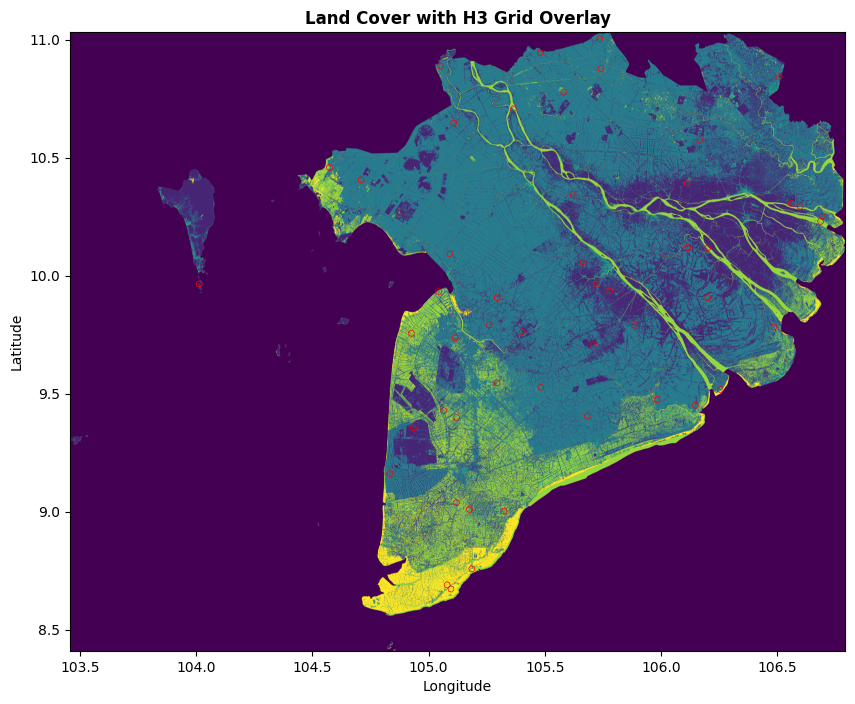

✅ Hoàn tất kiểm tra trực quan.


In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd

# Kiểm tra nếu h3_gdf đã tồn tại
if 'h3_gdf' in locals() and not h3_gdf.empty:
    print("Đang tải dữ liệu Land Cover để kiểm tra...")

    # Mở file Land Cover
    with rasterio.open(landcover_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))

        # Hiển thị dữ liệu Land Cover
        show(src, ax=ax, cmap='viridis', title='Land Cover with H3 Grid Overlay')

        # Lấy một vài ô H3 ngẫu nhiên để hiển thị (tránh vẽ quá nhiều gây chậm)
        # hoặc bạn có thể chọn một khu vực cụ thể
        sample_h3_cells = h3_gdf.sample(min(50, len(h3_gdf))) # Lấy tối đa 50 ô ngẫu nhiên

        # Vẽ đường viền của các ô H3 lên trên raster
        sample_h3_cells.boundary.plot(ax=ax, color='red', linewidth=0.5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.show()
        print("✅ Hoàn tất kiểm tra trực quan.")
else:
    print("⚠️ Không tìm thấy 'h3_gdf'. Vui lòng chạy lại phần 3.3 'Chạy xử lý static features' để tạo h3_gdf trước.")


Hình ảnh trên hiển thị dữ liệu Land Cover với đường viền màu đỏ của một số ô H3 được vẽ đè lên. Bạn có thể phóng to hình ảnh để kiểm tra kỹ hơn xem các ô H3 có khớp với ranh giới của các vùng dữ liệu raster hay không. Hàm `rasterio.mask.mask` đã được sử dụng để cắt dữ liệu raster theo từng polygon H3, nên về mặt kỹ thuật, dữ liệu được trích xuất đã nằm bên trong các ranh giới H3.

In [ ]:
if 'h3_gdf' in locals() and not h3_gdf.empty:
    # Bỏ cột tạm
    h3_output = h3_gdf.drop(columns=['total_landcover_pct'], errors='ignore')

    # Lưu GeoJSON (giữ geometry)
    geojson_path = os.path.join(data_folder, 'H3_Static_Features.geojson')
    h3_output.to_file(geojson_path, driver='GeoJSON')
    print(f"💾 GeoJSON: {geojson_path}")

    # Lưu CSV (bỏ geometry)
    csv_output_path = os.path.join(data_folder, 'H3_Static_Features.csv')
    h3_output.drop(columns='geometry').to_csv(csv_output_path, index=False)
    print(f"💾 CSV: {csv_output_path}")

    # Hiển thị 5 dòng đầu (với các cột quan trọng)
    print("\n=== KẾT QUẢ (5 dòng đầu) ===")
    display_cols = ['h3_index', 'pct_water', 'pct_crop', 'pct_built', 'pct_tree', 'pct_water_river']
    if 'landcover_label' in h3_output.columns:
        display_cols.append('landcover_label')
    if 'landcover_label_refined' in h3_output.columns:
        display_cols.append('landcover_label_refined')

    print(h3_output[display_cols].head().to_string())

    print(f"\n✅ HOÀN TẤT! Tổng {len(h3_output)} ô H3 có static features + landcover labels")


💾 GeoJSON: /content/drive/MyDrive/Du_Lieu_DBSCL/H3_Static_Features.geojson
💾 CSV: /content/drive/MyDrive/Du_Lieu_DBSCL/H3_Static_Features.csv

=== KẾT QUẢ (5 dòng đầu) ===
          h3_index  pct_water  pct_crop  pct_built   pct_tree  pct_water_river landcover_label landcover_label_refined
0  8765a19b6ffffff  13.464286  0.000000   0.000000  84.321429         3.949495   Land-dominant           Land-dominant
1  8765a1d62ffffff  21.897640  0.701098   0.584249   5.281608        21.888889           Mixed                   Mixed
2  8765a1d75ffffff  39.189189  0.000000   0.667123   1.300034        28.868687           Mixed                   Mixed
3  8765a1d74ffffff  28.170873  0.000000   0.115454   0.791687        20.112011           Mixed                   Mixed
4  8765a1d44ffffff   2.292950  0.085558   0.222450   2.806297        19.404040           Mixed                   Mixed

✅ HOÀN TẤT! Tổng 6752 ô H3 có static features + landcover labels
